In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.ndimage import gaussian_filter, geometric_transform
from rosat_xray_stacker import rosat_xray_stacker, measure_optimal_snr, get_intensity_profile_physical
from photutils import DAOStarFinder, CircularAperture
from photutils.segmentation import make_source_mask
from astropy.stats import sigma_clipped_stats
from matplotlib.colors import LogNorm
from seaborn import kdeplot
from scipy.stats import binned_statistic

In [2]:
ls *.py

make_custom_mosaics.py        rosat_xray_stacker.py
makelookuptable.py            skyview_downloader.py
mask_published_pt_sources.py  stacking_for_eco_broad.py
read_2rxs.py                  stacking_for_eco_hard.py
resb_xraystacking.py          stacking_for_eco_soft.py


# RESOLVE and ECO figures

In [3]:
eco = pd.read_csv("../g3groups/ECOdata_G3catalog_luminosity.csv")
eco = eco[(eco.absrmag<=-17.33)&(eco.g3grpcz_l>3000.)&(eco.g3grpcz_l<7000.)]
eco.loc[:,'g3grpn_l']=eco.g3grpngi_l+eco.g3grpndw_l

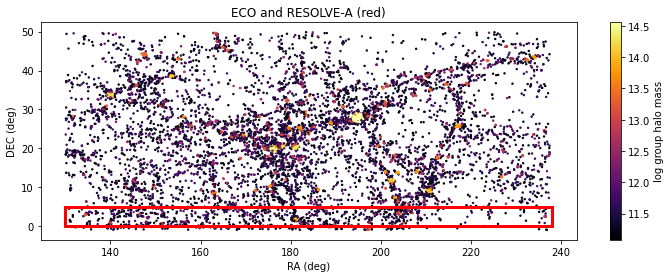

In [4]:
plt.figure(figsize=(12,4))
sc=plt.scatter(eco.radeg,eco.dedeg,s=2,c=eco.g3logmh_l,cmap='inferno')
plt.colorbar(sc,label='log group halo mass')
rect=plt.Rectangle((130,0),108,5,edgecolor='red',facecolor='none',linewidth=3)
plt.gca().add_patch(rect)
plt.xlabel("RA (deg)")
plt.ylabel("DEC (deg)")
plt.title("ECO and RESOLVE-A (red)")
plt.show()

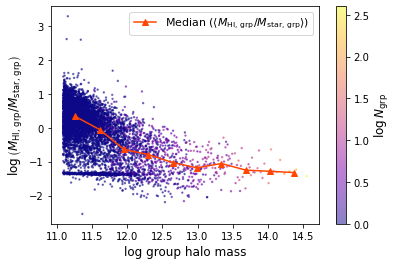

In [5]:
plt.figure()
tmp = eco[eco.g3fc_l==1.]
sc=plt.scatter(tmp.g3logmh_l, np.log10(10**tmp.g3grplogG_l/10**tmp.g3grplogS_l), alpha=0.5, s=2, c=np.log10(tmp.g3grpn_l), cmap='plasma')
plt.colorbar(sc).set_label(r'$\log N_{\rm grp}$',size=12)
#kdeplot(tmp.g3logmh_l, y=np.log10(10**tmp.g3grplogG_l/10**tmp.g3grplogS_l),color='k')
median, bedges, _ = binned_statistic(tmp.g3logmh_l, np.log10(10**tmp.g3grplogG_l/10**tmp.g3grplogS_l), 'median', bins=10)
plt.plot(0.5*(bedges[:-1]+bedges[1:]), median, '^-', color='orangered', label=r'Median ($\left<M_{\rm HI,\, grp} / M_{\rm star,\, grp}\right>$)')
plt.xlabel("log group halo mass",fontsize=12)
plt.ylabel(r"$\log\left(M_{\rm HI,\, grp} / M_{\rm star,\, grp}\right)$",fontsize=12)
plt.legend(loc='best',fontsize=11)
plt.show()

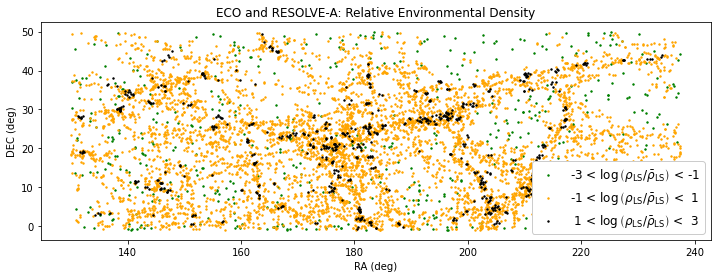

In [6]:
nndens2d = (10**tmp.g3grpnndens2d_l/tmp.g3grpedgescale2d_l)
nndens2d = np.log10(nndens2d/np.median(nndens2d))

plt.figure(figsize=(12,4))
sel = (nndens2d>-3)&(nndens2d<-1)
sc=plt.scatter(tmp.radeg[sel],tmp.dedeg[sel],s=2,c='green', label=r'-3 < $\log\left(\rho_{\rm LS}/\bar{\rho}_{\rm LS}\right)$ < -1')
sel = (nndens2d>-1)&(nndens2d<1)
sc=plt.scatter(tmp.radeg[sel],tmp.dedeg[sel],s=2,c='orange', label=r'-1 < $\log\left(\rho_{\rm LS}/\bar{\rho}_{\rm LS}\right)$ <  1')
sel = (nndens2d>1)&(nndens2d<3)
sc=plt.scatter(tmp.radeg[sel],tmp.dedeg[sel],s=2,c='black', label=r' 1 < $\log\left(\rho_{\rm LS}/\bar{\rho}_{\rm LS}\right)$ <  3')
plt.ylabel("DEC (deg)")
plt.xlabel("RA (deg)")
plt.title("ECO and RESOLVE-A: Relative Environmental Density")
plt.legend(loc='lower right', framealpha=1,fontsize=12)
plt.show()

In [7]:
tmp.loc[:,'nndens2d']=nndens2d
tmp.nndens2d[tmp.g3grp_l==14]

/tmp/ipykernel_324218/1374473428.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp.loc[:,'nndens2d']=nndens2d


3821    2.458487
Name: nndens2d, dtype: float64

# data processing figures 

### point source removal

In [8]:
img = fits.open("./g3rassimages/broad/eco_broad_cts/RASS-Cnt_Broad_grp14.0.fits")[0].data
smoothimg = gaussian_filter(img, sigma=1.)
mean, median, std = sigma_clipped_stats(img[img!=0],sigma=3, maxiters=2, cenfunc=np.mean)
daofind = DAOStarFinder(fwhm=3, threshold=mean+5*std)
table = daofind.find_stars(smoothimg)

if table is not None:
    # create and apply masks (unless it is a diffuse bright source?)
    positions=np.transpose(np.array([table['xcentroid'],table['ycentroid']]))
    apertures=CircularAperture(positions,r=5)
    masks=apertures.to_mask(method='center')
    # Create new image
    newimage = np.zeros_like(img)
    newmask = np.zeros_like(img)
    newmask = np.sum(np.array([msk.to_image(shape=((512,512))) for msk in masks]), axis=0)

    replacesel = np.logical_and(newmask>0,img>mean+std)
    newimage[replacesel] = mean
    newimage[~replacesel] = img[~replacesel]

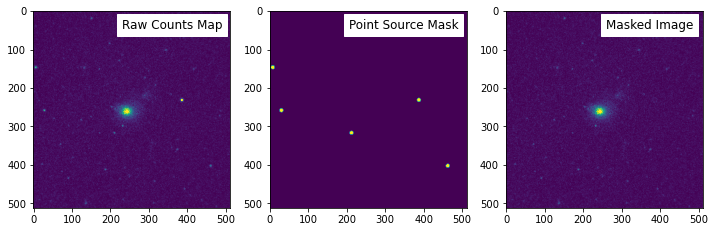

In [9]:
fig,axs=plt.subplots(ncols=3,figsize=(12,4))
axs[0].imshow(img,vmin=0,vmax=15)
axs[0].annotate("Raw Counts Map",xy=(230,45),backgroundcolor='white',fontsize=12)
axs[1].imshow(newmask)
axs[1].annotate("Point Source Mask",xy=(205,45),backgroundcolor='white',fontsize=12)
axs[2].imshow(newimage,vmin=0,vmax=15)
axs[2].annotate("Masked Image",xy=(260,45),backgroundcolor='white',fontsize=12)
plt.show()

### image rescaling

In [10]:
img = newimage

In [11]:
def scale_image(output_coords,scale,imwidth):
    mid = imwidth//2
    x = (output_coords[0]/scale+mid-mid/scale, output_coords[1]/scale+mid-mid/scale)
    return x
rescaled = geometric_transform(img, scale_image, cval=0, extra_keywords={'scale':5500/7000, 'imwidth':512})

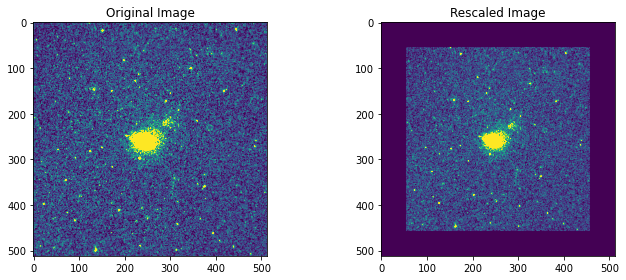

In [12]:
fig,axs=plt.subplots(ncols=2,figsize=(10,4))
axs[0].imshow(10*img, vmin=0, vmax=20)
axs[0].set_title("Original Image")
axs[1].imshow(10*rescaled, vmin=0, vmax=20)
rect = plt.Rectangle((50,50), 410, 410, edgecolor='red', facecolor='None')
#axs[1].add_patch(rect)
axs[1].set_title("Rescaled Image")
plt.tight_layout()
plt.show()

### mosaics

In [13]:
from astropy.coordinates import SkyCoord
from reproject.mosaicking import reproject_and_coadd, find_optimal_celestial_wcs
import astropy.units as uu
def mosaic_single_group(groupid, groupra, groupdec, count_paths, outsz, outdir, savehandle, method):
    cname=count_paths[0]
    coords=SkyCoord(ra=groupra*uu.degree,dec=groupdec*uu.degree)
    chdus = [fits.open(xx)[0] for xx in cname]
    wcs_out,shape_out = find_optimal_celestial_wcs(chdus)
    return reproject_and_coadd(chdus,output_projection=wcs_out,shape_out=shape_out,reproject_function=method)

In [14]:
from make_custom_mosaics import get_neighbor_images
from reproject import reproject_interp
from matplotlib.colors import LogNorm
eco = pd.read_csv("../g3groups/ECOdata_G3catalog_luminosity.csv")
eco = eco[eco.g3fc_l==1]

rasstable = pd.read_csv("RASS_public_contents_lookup.csv")
econame=np.array(eco.name,dtype=object)
names=get_neighbor_images(eco.g3grpradeg_l, eco.g3grpdedeg_l, rasstable.ra, rasstable.dec, rasstable.image, 5)

exposuremaps=np.zeros_like(names,dtype='object')
countmaps=np.zeros_like(names,dtype='object')
for ii,subarr in enumerate(names):
    for jj,name in enumerate(subarr):
        obs=name.split('.')[0]
        countmaps[ii][jj]='../rass/'+obs+'/'+obs+'_im1.fits'
        exposuremaps[ii][jj]='../rass/'+obs+'/'+obs+'_mex.fits'

grpid = np.array(eco.g3grp_l)
grpra = np.array(eco.g3grpradeg_l)
grpde = np.array(eco.g3grpdedeg_l)

In [15]:
sel = np.where(grpid==433.)
mosaic, fp = mosaic_single_group(grpid[sel],grpra[sel],grpde[sel],countmaps[sel],None,None,None,reproject_interp)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Invalid parameter values: MJD-OBS and DATE-OBS are inconsistent.
Changed DATE-OBS from '16/11/90' to '1990-11-16''. [astropy.wcs.wcs]
Invalid parameter values: MJD-OBS and DATE-OBS are inconsistent.
Changed DATE-OBS from '09/11/90' to '1990-11-09''. [astropy.wcs.wcs]
Invalid parameter values: MJD-OBS and DATE-OBS are inconsistent.
Changed DATE-OBS from '11/11/90' to '1990-11-11''. [astropy.wcs.wcs]
Invalid parameter values: MJD-OBS and DATE-OBS are inconsistent.
Changed DATE-OBS from '22/11/90' to '1990-11-22''. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Invalid parameter values: MJD-OBS and DATE-OBS are inconsistent.
Changed DATE-OBS from '16/11/90' to '1990-11-16''. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Invalid parameter values: MJD-OBS and DATE-OBS are inconsistent.
Changed DATE-OBS from '09/11/90' to '1990-11-09''. [astropy.w

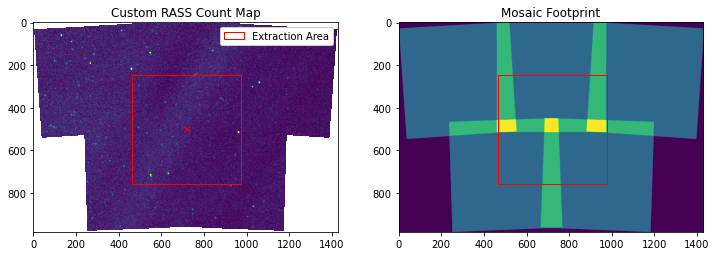

In [16]:
fig,axs = plt.subplots(ncols=2,nrows=1,figsize=(12,4))
axs[0].imshow(mosaic,vmin=0,vmax=4,cmap='viridis')
axs[0].plot(720,500,'rx')
rect = plt.Rectangle((720-512//2,500-512//2), 512, 512, edgecolor='red',facecolor='None',label='Extraction Area')
axs[0].add_patch(rect)
axs[0].legend(loc='best', framealpha=1)

axs[1].imshow(fp)
rect = plt.Rectangle((720-512//2,500-512//2), 512, 512, edgecolor='red',facecolor='None')
axs[1].add_patch(rect)

axs[0].set_title("Custom RASS Count Map",fontsize=12)
axs[1].set_title("Mosaic Footprint")
plt.show()

-----------------
# stacking figures



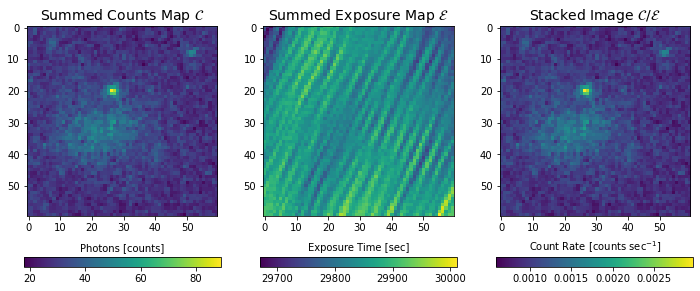

In [17]:
fig, axs = plt.subplots(ncols=3,figsize=(12,5))
cmap = fits.open("counts3broad.fits")[0].data
stack = fits.open('stack3broad.fits')[0].data
emap = cmap/stack
shw=axs[0].imshow(cmap)
axs[0].set_title(r"Summed Counts Map $\mathcal{C}$",fontsize=14)
clb=fig.colorbar(shw,orientation='horizontal',ax=axs[0],pad=0.15)
clb.ax.set_title('Photons [counts]', fontsize=10)


shw=axs[1].imshow(emap)
clb=fig.colorbar(shw,orientation='horizontal',ax=axs[1],pad=0.15)
clb.ax.set_title('Exposure Time [sec]', fontsize=10)
axs[1].set_title(r"Summed Exposure Map $\mathcal{E}$",fontsize=14)

shw=axs[2].imshow(stack)
clb=fig.colorbar(shw,orientation='horizontal',ax=axs[2],pad=0.15)
clb.ax.set_title(r'Count Rate [counts sec$^{-1}$]', fontsize=10)

axs[2].set_title(r"Stacked Image $\mathcal{C}/\mathcal{E}$",fontsize=14)
plt.show()

## [1] broadband stacking

In [18]:
ecocsv = pd.read_csv("../g3groups/ECOdata_G3catalog_luminosity.csv")
ecocsv = ecocsv[ecocsv.g3fc_l==1.0] # centrals only
eco = rosat_xray_stacker(ecocsv.g3grp_l, ecocsv.g3grpradeg_l, ecocsv.g3grpdedeg_l, ecocsv.g3grpcz_l, centralname=ecocsv.name, \
    surveys=['RASS-Int Broad'])
stackID,nbin,bincenters,counts=eco.stack_images("./g3rassimages/broad/eco_broad_cts_scaled/",np.asarray(ecocsv.g3logmh_l), binedges=[11,12.1,13.3,15])
stackID,nbin,bincenters,times=eco.stack_images("./g3rassimages/broad/eco_broad_exp_scaled/",np.asarray(ecocsv.g3logmh_l), binedges=[11,12.1,13.3,15])
stacks = [stackID,nbin,bincenters,counts,times]

AssertionError: Number of files in directory must match number of groups.

In [19]:
images = [ct/ex for (ct,ex) in zip(counts,times)]
binedges=[11,12.1,13.3,15]
visimages = [gaussian_filter(images[i],2) for i in range(0,len(images))]
Rvir = ((3*10**bincenters) / (4*np.pi*337*0.3*1.36e11) )**(1/3)
Rvir_px = Rvir/100 * 206265 / 45.
snrs = [measure_optimal_snr(images[ii],times[ii],7000,Rvir[ii])[0] for ii in range(0,len(images))]
apfrac = [measure_optimal_snr(images[ii],times[ii],7000,Rvir[ii])[1] for ii in range(0,len(images))]
fig, axs = plt.subplots(nrows=1, ncols=len(bincenters),figsize=(12,5))
for jj in range(0,len(bincenters)):
    shw = axs[jj].imshow(visimages[jj])
    clb=fig.colorbar(shw,orientation='horizontal',ax=axs[jj],pad=0.1)
    clb.ax.set_title('counts / sec', fontsize=10)
    circ=plt.Circle((visimages[jj].shape[0]//2, visimages[jj].shape[1]//2), 0.5*Rvir_px[jj],\
       edgecolor='red', facecolor='None')
    axs[jj].add_patch(circ)
    axs[jj].set_title("{:0.1f} < ".format(binedges[jj])+r"$\log M_{\rm halo}$ < " + "{:0.1f}".format(binedges[jj+1]))
    axs[jj].annotate(r"{} Images".format(nbin[jj]), xy=(2,6), backgroundcolor='white',fontsize=11)
    axs[jj].annotate(r"$S/N = $"+"{:0.3f}".format(snrs[jj]), xy=(2,13), backgroundcolor='white',fontsize=11)
    sel = (ecocsv.g3logmh_l>binedges[jj]) & (ecocsv.g3logmh_l<binedges[jj+1])
    mediangrpgs = np.median((10**ecocsv[sel].g3grplogG_l/10**ecocsv[sel].g3grplogS_l))
    axs[jj].annotate(r"$\left<{M_{\rm HI,\, grp}}/{M_{\rm star,\, grp}}\right>=$"+" {:0.3f}".format(mediangrpgs),xy=(8,55),backgroundcolor='white',fontsize=12)
plt.suptitle("Stacking RASS Broad: hot gas increases as cold gas richness decreases",fontsize=12)
plt.tight_layout()
plt.show()

NameError: name 'counts' is not defined

### env't density

In [ ]:
ecocsv = pd.read_csv("../g3groups/ECOdata_G3catalog_luminosity.csv")
ecocsv = ecocsv[ecocsv.g3fc_l==1.0] # centrals only
nndens2d = (10**ecocsv.g3grpnndens2d_l/ecocsv.g3grpedgescale2d_l)
nndens2d = np.log10(nndens2d/np.median(nndens2d))
eco = rosat_xray_stacker(ecocsv.g3grp_l, ecocsv.g3grpradeg_l, ecocsv.g3grpdedeg_l, ecocsv.g3grpcz_l, centralname=ecocsv.name, \
    surveys=['RASS-Int Broad'])
densedges = [-3,-1,1,3]
stackID,nbin,bincenters,counts=eco.stack_images("./g3rassimages/broad/eco_broad_cts_scaled/",np.asarray(nndens2d), binedges=densedges)
stackID,nbin,bincenters,times=eco.stack_images("./g3rassimages/broad/eco_broad_exp_scaled/",np.asarray(nndens2d), binedges=densedges)
stacks = [stackID,nbin,bincenters,counts,times]

In [ ]:
images = [ct/ex for (ct,ex) in zip(counts,times)]
binedges=densedges
visimages = [gaussian_filter(images[i],2) for i in range(0,len(images))]
Rvir = np.array([1,1,1])#((3*10**bincenters) / (4*np.pi*337*0.3*1.36e11) )**(1/3)
Rvir_px = Rvir/100 * 206265 / 45.
snrs = [measure_optimal_snr(images[ii],times[ii],7000,Rvir[ii])[0] for ii in range(0,len(images))]
cbranges=[np.linspace(0.00082, 0.000923,4),np.linspace(0.000843,0.0008653,4), np.linspace(0.00086,0.00096,4)]
apfrac = [measure_optimal_snr(images[ii],times[ii],7000,Rvir[ii])[1] for ii in range(0,len(images))]
fig, axs = plt.subplots(nrows=1, ncols=len(bincenters),figsize=(12,5))
for jj in range(0,len(bincenters)):
    shw = axs[jj].imshow(visimages[jj])
    clb=fig.colorbar(shw,orientation='horizontal',ax=axs[jj],pad=0.1)
    clb.ax.set_title('counts / sec', fontsize=10)
    clb.ax.set_xticks(cbranges[jj])
    clb.ax.set_title('counts / sec', fontsize=10)
    circ=plt.Circle((visimages[jj].shape[0]//2, visimages[jj].shape[1]//2), 0.5*Rvir_px[jj],\
       edgecolor='red', facecolor='None')
    axs[jj].add_patch(circ)
    axs[jj].set_title("{:0.1f} < ".format(binedges[jj])+r"$\log\left(\rho_{\rm LS}/\bar{\rho}_{\rm LS}\right)$ < " + "{:0.1f}".format(binedges[jj+1]))
    axs[jj].annotate(r"{} Images".format(nbin[jj]), xy=(2,6), backgroundcolor='white',fontsize=11)
    axs[jj].annotate(r"$S/N = $"+"{:0.3f}".format(snrs[jj]), xy=(2,13), backgroundcolor='white',fontsize=11)
    sel = (nndens2d>binedges[jj]) & (nndens2d<binedges[jj+1])
    print(min(ecocsv[sel].g3logmh_l), max(ecocsv[sel].g3logmh_l))
    print(min(ecocsv.g3logmh_l))
    mediangrpgs = np.median((10**ecocsv[sel].g3grplogG_l/10**ecocsv[sel].g3grplogS_l))
    axs[jj].annotate(r"$\left<{M_{\rm HI,\, grp}}/{M_{\rm star,\, grp}}\right>=$"+" {:0.3f}".format(mediangrpgs),xy=(8,55),backgroundcolor='white',fontsize=12)
plt.suptitle("Stacking RASS Broad: hot gas most prominent in density extrema; cold gas decreasing with density",fontsize=12)
plt.tight_layout()
plt.show()

# [2] hardband stacking

In [ ]:
ecocsv = pd.read_csv("../g3groups/ECOdata_G3catalog_luminosity.csv")
ecocsv = ecocsv[ecocsv.g3fc_l==1.0] # centrals only
eco = rosat_xray_stacker(ecocsv.g3grp_l, ecocsv.g3grpradeg_l, ecocsv.g3grpdedeg_l, ecocsv.g3grpcz_l, centralname=ecocsv.name, \
    surveys=['RASS-Int Hard'])
stackID,nbin,bincenters,counts=eco.stack_images("./g3rassimages/hard/eco_hard_cts_scaled/",np.asarray(ecocsv.g3logmh_l), binedges=[11,12.1,13.3,15])
stackID,nbin,bincenters,times=eco.stack_images("./g3rassimages/hard/eco_hard_exp_scaled/",np.asarray(ecocsv.g3logmh_l), binedges=[11,12.1,13.3,15])
stacks = [stackID,nbin,bincenters,counts,times]

In [ ]:
images = [ct/ex for (ct,ex) in zip(counts,times)]
binedges=[11,12.1,13.3,15]
visimages = [gaussian_filter(images[i],2) for i in range(0,len(images))]
Rvir = ((3*10**bincenters) / (4*np.pi*337*0.3*1.36e11) )**(1/3)
Rvir_px = Rvir/100 * 206265 / 45.
snrs = [measure_optimal_snr(images[ii],times[ii],7000,Rvir[ii])[0] for ii in range(0,len(images))]
apfrac = [measure_optimal_snr(images[ii],times[ii],7000,Rvir[ii])[1] for ii in range(0,len(images))]
cbranges = [np.linspace(0.00019,0.000204,4), np.linspace(0.00019,0.00025,4), np.linspace(0.0002,0.00058,4)]
fig, axs = plt.subplots(nrows=1, ncols=len(bincenters),figsize=(12,5))
for jj in range(0,len(bincenters)):
    shw = axs[jj].imshow(visimages[jj])
    clb=fig.colorbar(shw,orientation='horizontal',ax=axs[jj],pad=0.1)
    clb.ax.set_xticks(cbranges[jj])
    clb.ax.set_title('counts / sec', fontsize=10)
    circ=plt.Circle((visimages[jj].shape[0]//2, visimages[jj].shape[1]//2), 0.5*Rvir_px[jj],\
       edgecolor='red', facecolor='None')
    axs[jj].add_patch(circ)
    axs[jj].set_title("{:0.1f} < ".format(binedges[jj])+r"$\log M_{\rm halo}$ < " + "{:0.1f}".format(binedges[jj+1]))
    axs[jj].annotate(r"{} Images".format(nbin[jj]), xy=(2,6), backgroundcolor='white',fontsize=11)
    axs[jj].annotate(r"$S/N = $"+"{:0.3f}".format(snrs[jj]), xy=(2,13), backgroundcolor='white',fontsize=11)
    sel = (ecocsv.g3logmh_l>binedges[jj]) & (ecocsv.g3logmh_l<binedges[jj+1])
    mediangrpgs = np.median((10**ecocsv[sel].g3grplogG_l/10**ecocsv[sel].g3grplogS_l))
    axs[jj].annotate(r"$\left<{M_{\rm HI,\, grp}}/{M_{\rm star,\, grp}}\right>=$"+" {:0.3f}".format(mediangrpgs),xy=(8,55),backgroundcolor='white',fontsize=12)
plt.suptitle("Stacking RASS Hard: hot gas increases as cold gas richness decreases",fontsize=12)
plt.tight_layout()
plt.show()

### env't density

In [ ]:
ecocsv = pd.read_csv("../g3groups/ECOdata_G3catalog_luminosity.csv")
ecocsv = ecocsv[ecocsv.g3fc_l==1.0] # centrals only
nndens2d = (10**ecocsv.g3grpnndens2d_l/ecocsv.g3grpedgescale2d_l)
nndens2d = np.log10(nndens2d/np.median(nndens2d))
eco = rosat_xray_stacker(ecocsv.g3grp_l, ecocsv.g3grpradeg_l, ecocsv.g3grpdedeg_l, ecocsv.g3grpcz_l, centralname=ecocsv.name, \
    surveys=['RASS-Int Hard'])
densedges = [-3,-1,1,3]
stackID,nbin,bincenters,counts=eco.stack_images("./g3rassimages/hard/eco_hard_cts_scaled/",np.asarray(nndens2d), binedges=densedges)
stackID,nbin,bincenters,times=eco.stack_images("./g3rassimages/hard/eco_hard_exp_scaled/",np.asarray(nndens2d), binedges=densedges)
stacks = [stackID,nbin,bincenters,counts,times]

In [ ]:
images = [ct/ex for (ct,ex) in zip(counts,times)]
binedges=densedges
visimages = [gaussian_filter(images[i],2) for i in range(0,len(images))]
Rvir = np.array([1,1,1])#((3*10**bincenters) / (4*np.pi*337*0.3*1.36e11) )**(1/3)
Rvir_px = Rvir/100 * 206265 / 45.
snrs = [measure_optimal_snr(images[ii],times[ii],7000,Rvir[ii])[0] for ii in range(0,len(images))]
apfrac = [measure_optimal_snr(images[ii],times[ii],7000,Rvir[ii])[1] for ii in range(0,len(images))]
cbranges = [np.linspace(0.00019,0.00025,4),np.linspace(0.000188,0.000203,4),np.linspace(0.00018,0.00024,4)]
fig, axs = plt.subplots(nrows=1, ncols=len(bincenters),figsize=(12,5))
for jj in range(0,len(bincenters)):
    shw = axs[jj].imshow(visimages[jj])
    clb=fig.colorbar(shw,orientation='horizontal',ax=axs[jj],pad=0.1)
    clb.ax.set_xticks(cbranges[jj])
    clb.ax.set_title('counts / sec', fontsize=10)
    circ=plt.Circle((visimages[jj].shape[0]//2, visimages[jj].shape[1]//2), 0.5*Rvir_px[jj],\
       edgecolor='red', facecolor='None')
    axs[jj].add_patch(circ)
    axs[jj].set_title("{:0.1f} < ".format(binedges[jj])+r"$\log\left(\rho_{\rm LS}/\bar{\rho}_{\rm LS}\right)$ < " + "{:0.1f}".format(binedges[jj+1]))
    axs[jj].annotate(r"{} Images".format(nbin[jj]), xy=(2,6), backgroundcolor='white',fontsize=11)
    axs[jj].annotate(r"$S/N = $"+"{:0.3f}".format(snrs[jj]), xy=(2,13), backgroundcolor='white',fontsize=11)
    sel = (nndens2d>binedges[jj]) & (nndens2d<binedges[jj+1])
    mediangrpgs = np.median((10**ecocsv[sel].g3grplogG_l/10**ecocsv[sel].g3grplogS_l))
    axs[jj].annotate(r"$\left<{M_{\rm HI,\, grp}}/{M_{\rm star,\, grp}}\right>=$"+" {:0.3f}".format(mediangrpgs),xy=(8,55),backgroundcolor='white',fontsize=12)
plt.suptitle("Stacking RASS Hard: hot gas most prominent in density extrema; cold gas decreasing with density",fontsize=12)
plt.tight_layout()
plt.show()